# Intro to TabNet
**TabNet** is a deep neural network architecture for tabular data. [link to paper](https://arxiv.org/pdf/1908.07442.pdf)

According to the authors, TabNet **outperforms** or is **on par with** other tabular learning models on various datasets for classification and regression problems from different domains.

**Summary:**
- TabNet inputs raw tabular data *without any preprocessing* and is trained using *gradient descent-based optimisation*.
- TabNet uses *sequential attention* to choose features at each decision step, enabling interpretability and better learning as the learning capacity is used for the most useful features.
- Feature selection is *instance-wise*, e.g. it can be different for each input.
- TabNet employs a *single* deep learning architecture for feature selection and reasoning.
- TabNet enables two kinds of interpretability: *local interpretability* that visualizes the importance of features and how they are combined, and *global interpretability* which quantifies the contribution of each feature to the trained model.


In [1]:
import pandas as pd
import numpy as np

 Install the [PyTorch implementation of Tabnet by dreamquark-ai](https://github.com/dreamquark-ai/tabnet)

In [2]:
!pip install pytorch-tabnet

# Load data and split

In [3]:
df_train = pd.read_csv("/kaggle/input/widsdatathon2022/train.csv")
df_test = pd.read_csv("/kaggle/input/widsdatathon2022/test.csv")

In [4]:
target = 'site_eui'
if "Set" not in df_train.columns:
    df_train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(df_train.shape[0],))

train_indices = df_train[df_train.Set=="train"].index
valid_indices = df_train[df_train.Set=="valid"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [5]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = []
categorical_dims =  {}
for col in df_train.columns[df_train.dtypes == object]:
    print(col, df_train[col].nunique())
    l_enc = LabelEncoder()
    df_train[col] = df_train[col].fillna("VV_likely")
    df_train[col] = l_enc.fit_transform(df_train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in df_train.columns[df_train.dtypes == 'float64']:
    df_train.fillna(df_train.loc[train_indices, col].mean(), inplace=True)

State_Factor 7
building_class 2
facility_type 60
Set 2


# Define categorical features for categorical embeddings

In [6]:
unused_feat = ['Set']

features = [ col for col in df_train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [3, 1, 5]

# Network parameters

In [7]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

Device used : cuda


# Training

In [8]:
X_train = df_train[features].values[train_indices]
y_train = df_train[target].values[train_indices].reshape(-1, 1)

X_valid = df_train[features].values[valid_indices]
y_valid = df_train[target].values[valid_indices].reshape(-1, 1)

In [9]:
max_epochs = 500

In [10]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs=max_epochs,
    patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

epoch 0  | loss: 8344.84906| train_rmse: 74.19909| valid_rmse: 76.87009|  0:00:05s
epoch 1  | loss: 3323.53242| train_rmse: 59.17861| valid_rmse: 63.03045|  0:00:10s
epoch 2  | loss: 2816.51283| train_rmse: 58.80382| valid_rmse: 62.19687|  0:00:14s
epoch 3  | loss: 2696.60519| train_rmse: 53.14707| valid_rmse: 56.92508|  0:00:18s
epoch 4  | loss: 2622.69726| train_rmse: 51.02699| valid_rmse: 55.0308 |  0:00:23s
epoch 5  | loss: 2607.57897| train_rmse: 50.904  | valid_rmse: 54.9667 |  0:00:27s
epoch 6  | loss: 2580.92916| train_rmse: 50.60986| valid_rmse: 54.61693|  0:00:31s
epoch 7  | loss: 2569.75722| train_rmse: 50.45932| valid_rmse: 54.44941|  0:00:36s
epoch 8  | loss: 2562.66102| train_rmse: 50.73172| valid_rmse: 54.67785|  0:00:41s
epoch 9  | loss: 2547.50793| train_rmse: 50.67351| valid_rmse: 54.74056|  0:00:45s
epoch 10 | loss: 2558.25103| train_rmse: 50.17352| valid_rmse: 54.07556|  0:00:49s
epoch 11 | loss: 2532.07487| train_rmse: 50.0001 | valid_rmse: 53.96409|  0:00:54s
epoc

# Save model and load

In [11]:
# save tabnet model
saving_path_name = "./tabnet_model_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_1.zip


In [12]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

Device used : cuda
Device used : cuda


# Global explainability

In [13]:
clf.feature_importances_ # feature importance summing to 1

array([0.        , 0.0150689 , 0.        , 0.22744914, 0.00136044,
       0.        , 0.09552328, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01981795,
       0.0131637 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01503187, 0.        , 0.00274228, 0.        , 0.        ,
       0.        , 0.        , 0.14131394, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02085165, 0.        , 0.        ,
       0.05787978, 0.00225878, 0.31966118, 0.0678771 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [14]:
feat_imp = {'features': features,
           'importance': clf.feature_importances_}
feat_importance = pd.DataFrame(feat_imp)
feat_importance = feat_importance.sort_values(by=['importance'], ascending=False)
feat_importance.head(15) # top 15 most important features

,features,importance
47,snowfall_inches,0.319661
3,facility_type,0.227449
32,september_min_temp,0.141314
6,energy_star_rating,0.095523
48,snowdepth_inches,0.067877
45,heating_degree_days,0.057880
42,december_avg_temp,0.020852
14,march_min_temp,0.019818
1,State_Factor,0.015069
25,june_max_temp,0.015032


# Local explainability and masks

In [15]:
explain_matrix, masks = clf.explain(X_valid)

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

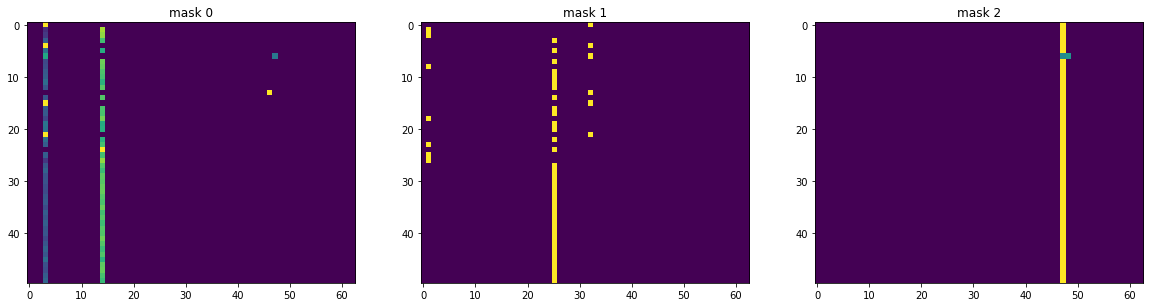

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# Submission

In [18]:
categorical_columns = []
categorical_dims =  {}
for col in df_test.columns[df_test.dtypes == object]:
    #print(col, df_test[col].nunique())
    l_enc = LabelEncoder()
    df_test[col] = df_test[col].fillna("VV_likely")
    df_test[col] = l_enc.fit_transform(df_test[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in df_test.columns[df_test.dtypes == 'float64']:
    df_test.fillna(df_test.loc[:, col].mean(), inplace=True)

In [19]:
X_test = df_test[features].values[:]

In [20]:
y_pred = loaded_clf.predict(X_test)

In [21]:
results = pd.DataFrame(df_test['id'])
results['site_eui'] = y_pred
results.head()

,id,site_eui
0,75757,233.240204
1,75758,233.239624
2,75759,233.241409
3,75760,233.240311
4,75761,233.240265


In [22]:
# write predictions to CSV
results.to_csv("submission.csv", header=True, index=False)

### Reference:
- https://github.com/dreamquark-ai/tabnet/blob/develop/regression_example.ipynb

#### /**/This notebook is a WORK IN PROGRESS/**/